All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and added later manually to the file after analysing the video frames. '1' indicates the eye-closed and '0' the eye-open state. All values are in chronological order with the first measured value at the top of the data.

In [73]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional, ReLU, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Add

In [30]:
data = arff.loadarff('EEG Eye State.arff')
df = pd.DataFrame(data[0])

df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'


In [31]:
df.shape

(14980, 15)

In [32]:
df['eyeDetection']=df.eyeDetection.astype(int)

In [33]:
df.eyeDetection.value_counts()

0    8257
1    6723
Name: eyeDetection, dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [35]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


Text(0.5, 1.0, 'Target distribution')

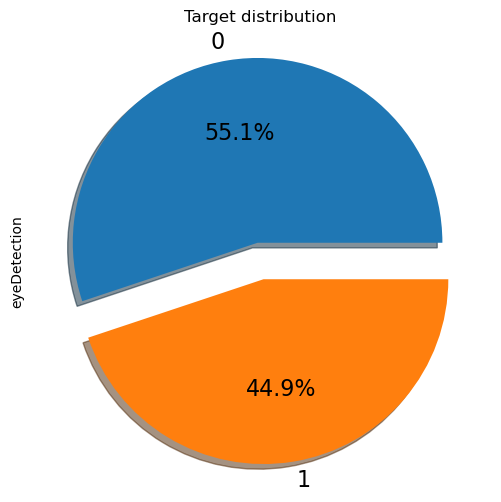

In [36]:
# Plotting target distribution 
plt.figure(figsize=(6,6))
df['eyeDetection'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


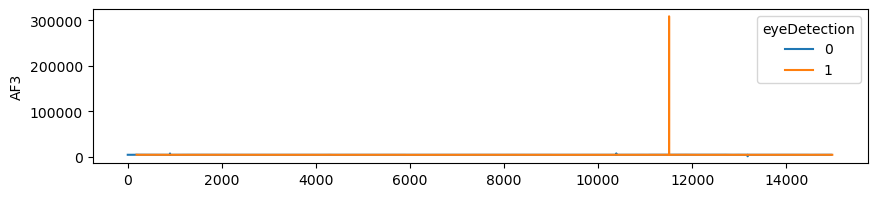

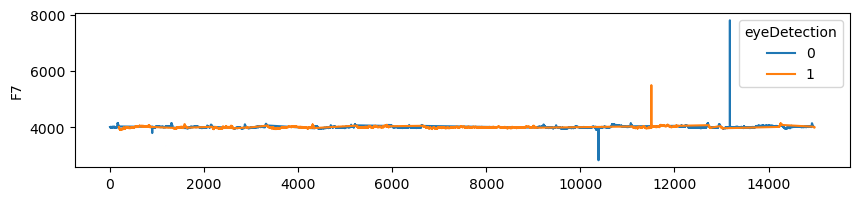

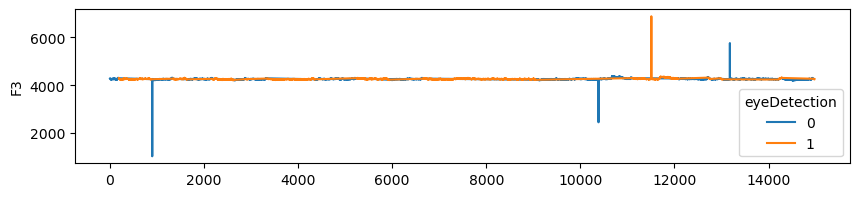

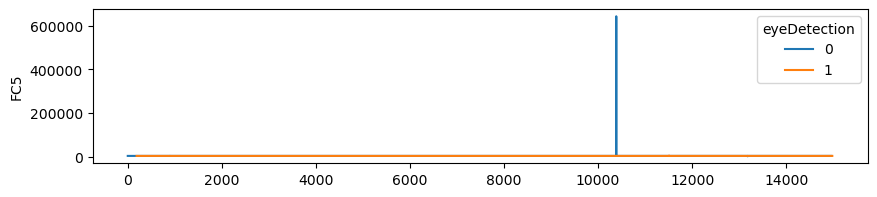

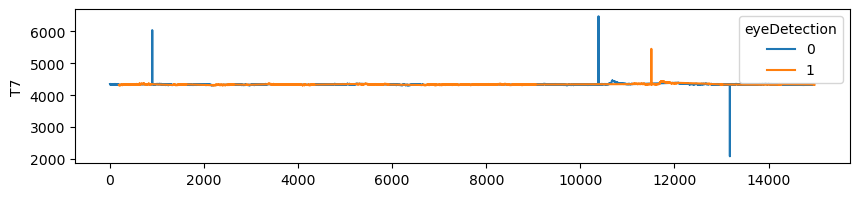

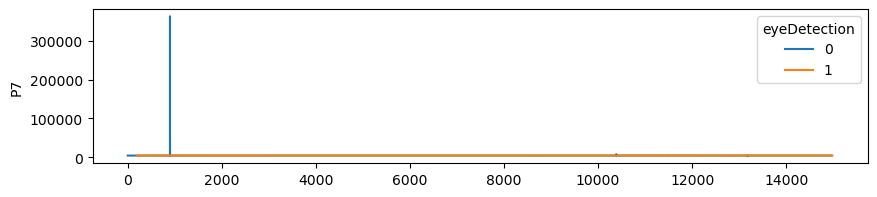

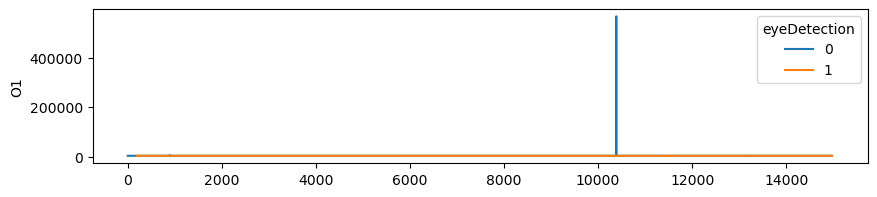

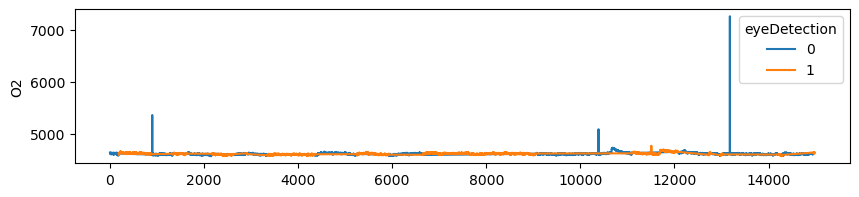

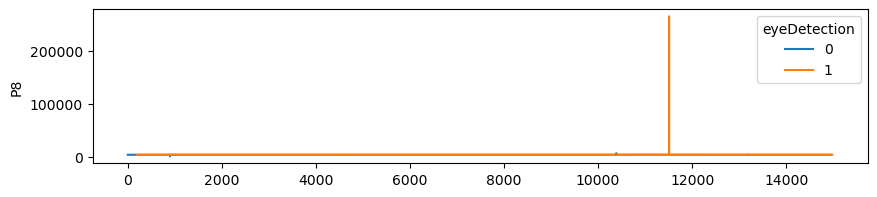

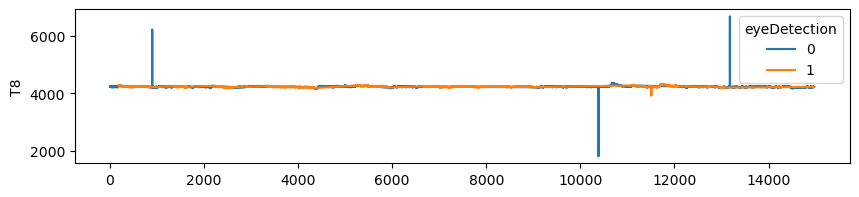

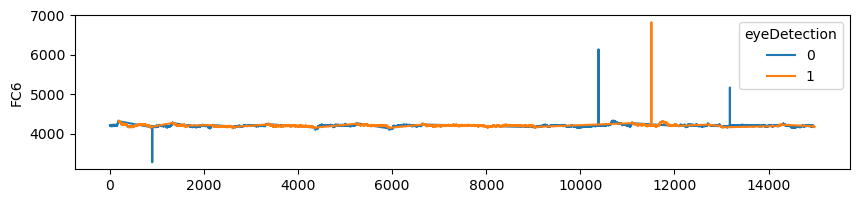

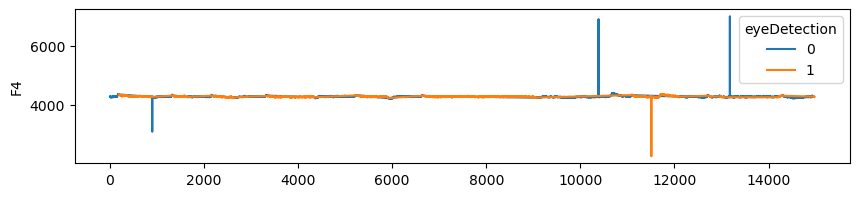

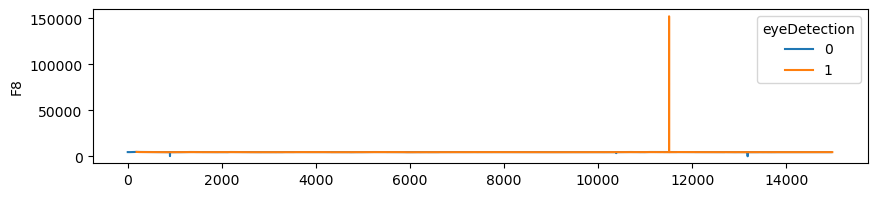

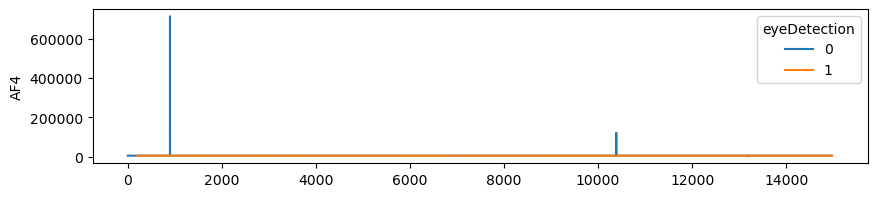

In [39]:
for col in df.columns[:-1]:
    plt.figure(figsize=(10, 2))
    sns.lineplot(x=df.index, y=col, data=df, hue="eyeDetection")
    plt.show()

### Outlier Handling

The Empirical Rule states that 99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean. Under this rule, 68% of the data falls within one standard deviation, 95% percent within two standard deviations, and 99.7% within three standard deviations from the mean. Z-scores represent the number of standard deviations a data point is away from the mean. 

In [40]:
df.shape

(14980, 15)

In [41]:
#removing extreme outliers only
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries].reset_index(drop=True)
df.shape

(14892, 15)

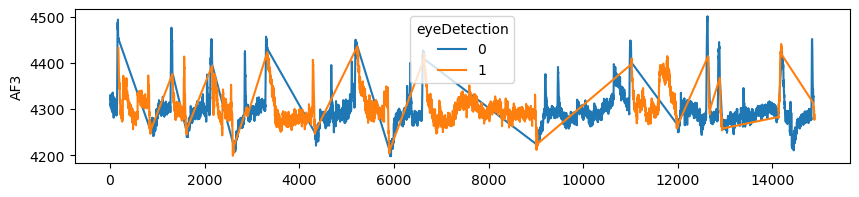

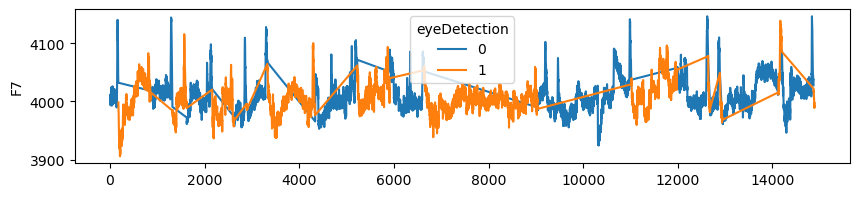

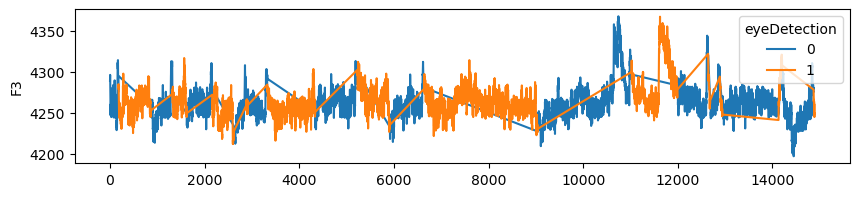

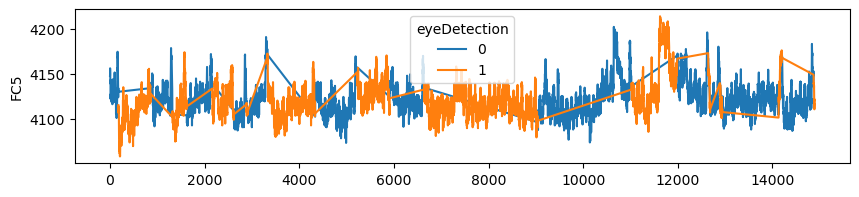

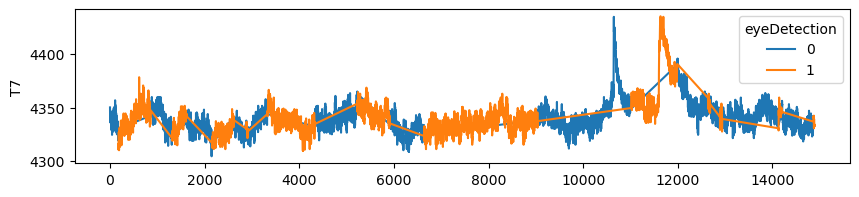

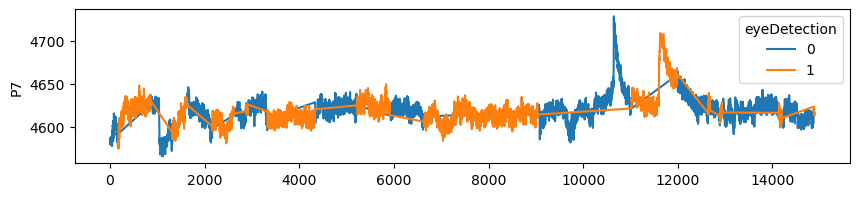

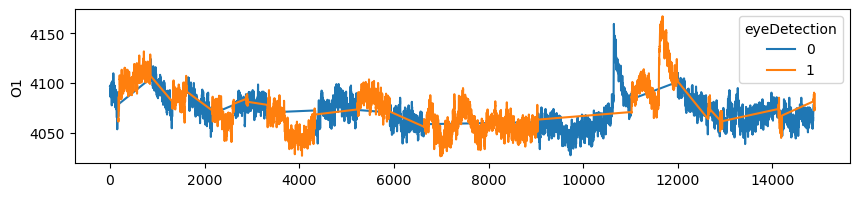

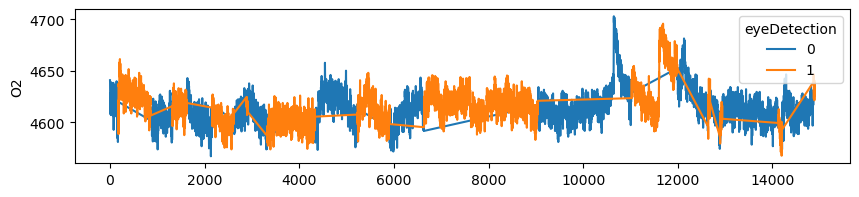

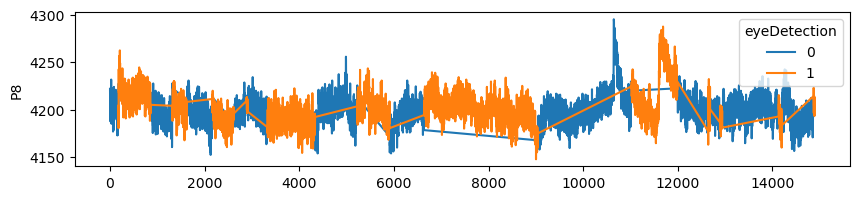

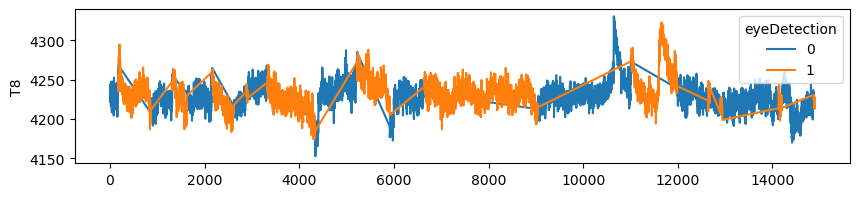

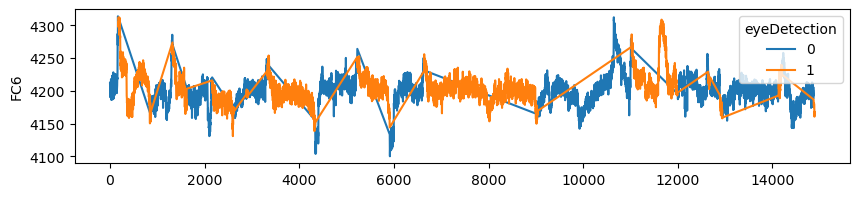

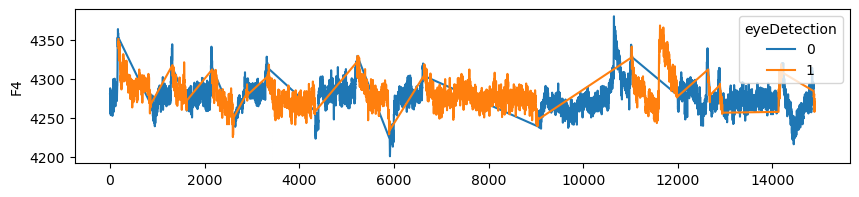

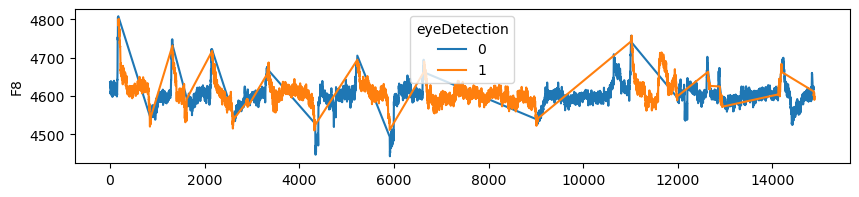

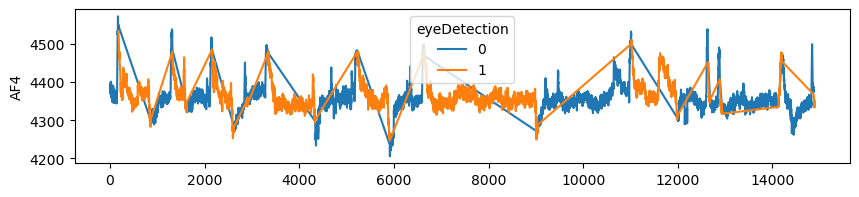

In [42]:
for col in df.columns[:-1]:
    plt.figure(figsize=(10, 2))
    sns.lineplot(x=df.index, y=col, data=df, hue="eyeDetection")
    plt.show()

Text(0.5, 1.0, 'Target distribution')

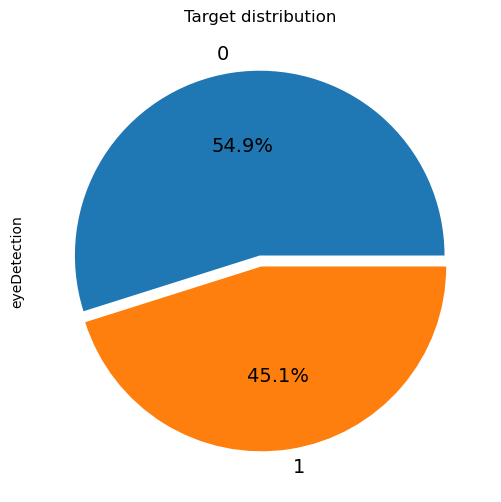

In [48]:
# Plotting target distribution 
plt.figure(figsize=(6,6))
df['eyeDetection'].value_counts().plot.pie(explode=[0.03,0.03], autopct='%1.1f%%', textprops={'fontsize':14}).set_title("Target distribution")

'1' indicates the eye-closed and '0' the eye-open state

In [49]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000,14892.000000
mean,4300.715364,4008.965647,4263.559657,4121.860899,4341.101970,4619.550090,4072.419849,4615.348947,4200.895893,4230.697654,4201.569780,4278.558803,4605.392896,4360.667174,0.451249
std,36.758734,29.214145,20.093688,19.707423,15.548446,16.649132,20.055635,17.101792,16.550328,18.349989,23.206287,18.791840,32.391422,37.571686,0.497634
min,4197.950000,3905.640000,4197.440000,4058.460000,4304.620000,4566.150000,4026.150000,4567.180000,4147.690000,4152.820000,4100.000000,4201.030000,4443.080000,4205.640000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4189.740000,4267.690000,4590.260000,4341.540000,0.000000
50%,4293.850000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.410000,4603.080000,4354.870000,0.000000
75%,4311.280000,4022.560000,4270.770000,4131.790000,4346.670000,4626.150000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.310000,1.000000
max,4501.030000,4146.670000,4367.690000,4214.360000,4435.380000,4728.210000,4167.180000,4703.080000,4295.380000,4330.770000,4313.850000,4380.510000,4808.210000,4573.330000,1.000000


<Axes: >

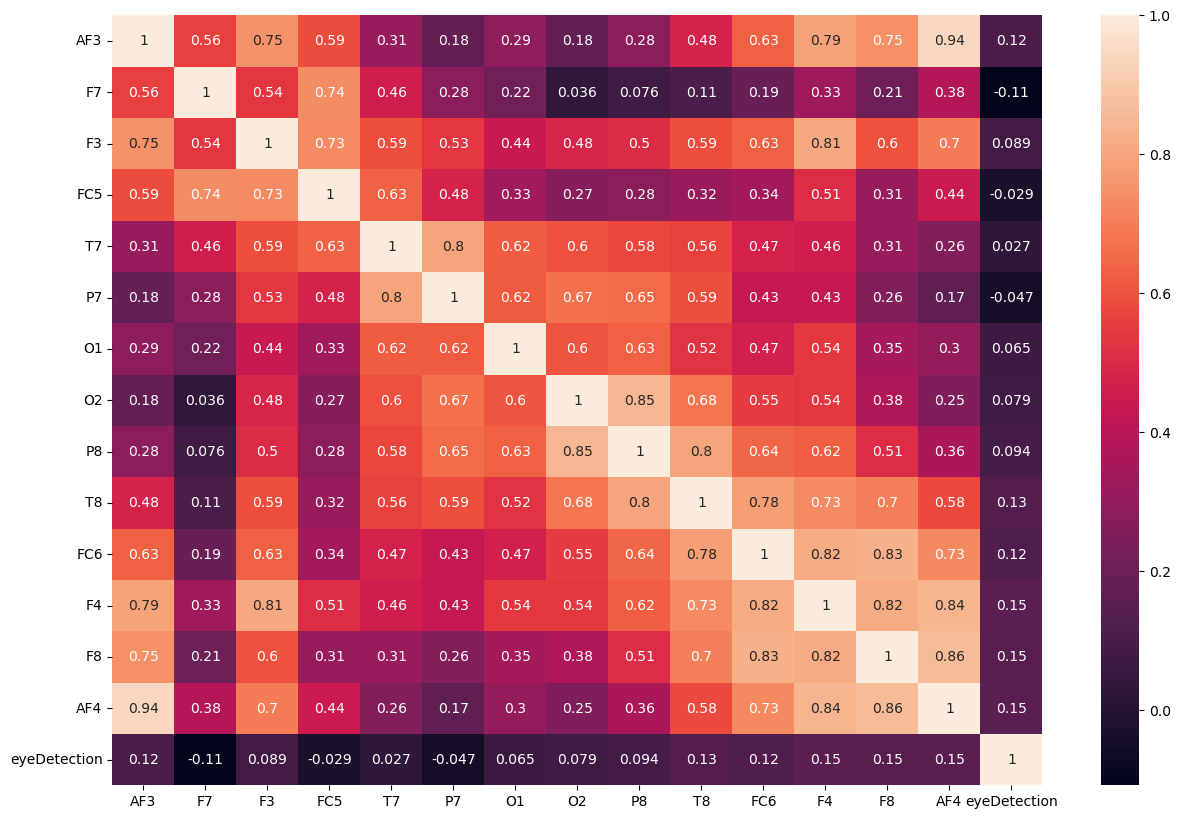

In [43]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

In [50]:
x = df.drop('eyeDetection', axis=1)
y = df['eyeDetection']

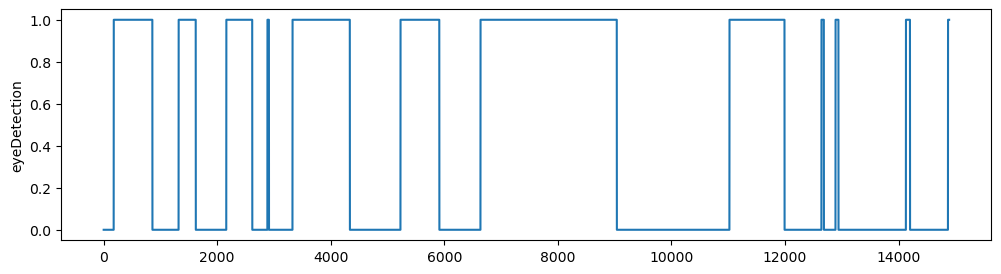

In [51]:
plt.figure(figsize=(12, 3))
sns.lineplot(x=df.index, y=df.columns[-1], data=df)
plt.show()

In [52]:
x_sc = StandardScaler().fit_transform(x)
x_train,x_test,y_train,y_test = train_test_split(x_sc,y,test_size=0.2, random_state=42)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(11913, 14) (2979, 14) (11913,) (2979,)


### Extra Trees Classifier

In [53]:
# The number of trees in the forest algorithm
n_estimators = [50, 100, 300, 500, 1000]

# The minimum number of samples required to split an internal node, default value is 2.
min_samples_split = [2, 3, 5, 7, 9]

# The minimum number of samples required to be at a leaf node, default value is 1.
min_samples_leaf = [1, 2, 4, 6, 8]

# The number of features to consider when looking for the best split
max_features = ['sqrt', 'log2', None] 

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [55]:
from sklearn.ensemble import ExtraTreesClassifier

best_model = ExtraTreesClassifier(random_state=42)

random_cv = RandomizedSearchCV(estimator=best_model,
                               param_distributions=hyperparameter_grid,
                               cv=5, n_iter=20, 
                               scoring = 'accuracy',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True, 
                               random_state=42)
random_cv.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 3, 5, 7, 9],
                                        'n_estimators': [50, 100, 300, 500,
                                                         1000]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=1)

In [56]:
random_cv.best_estimator_

ExtraTreesClassifier(max_features='log2', random_state=42)

                   Model  Accuracy  F1 Score       ROC
0  Extra Tree Classifier  0.952333  0.947717  0.990756


              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1591
           1       0.97      0.93      0.95      1388

    accuracy                           0.95      2979
   macro avg       0.95      0.95      0.95      2979
weighted avg       0.95      0.95      0.95      2979



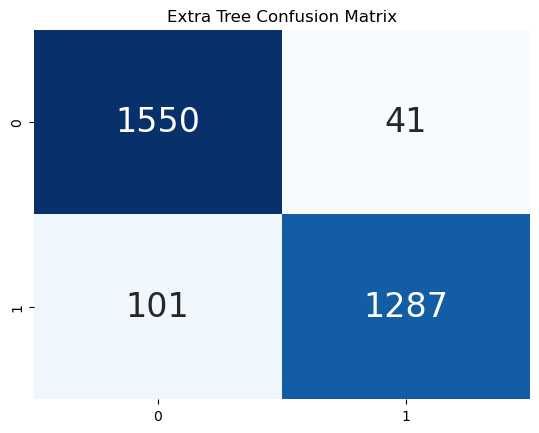

In [57]:
xtree = ExtraTreesClassifier(max_features='log2', random_state=42)
predictor_xtree = xtree.fit(x_train, y_train)
y_pred = predictor_xtree.predict(x_test)

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, xtree.predict_proba(x_test)[:, 1])
f1= f1_score(y_test, y_pred)

results = pd.DataFrame([['Extra Tree Classifier',acc, f1,roc]], columns = ['Model', 'Accuracy','F1 Score','ROC'])
print(results)
print('\n')
cm_xgb = confusion_matrix(y_test, y_pred)
plt.title("Extra Tree Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
print (classification_report(y_test, y_pred))

### XGBoost

     Model  Accuracy  F1 Score       ROC
0  xgboost  0.930514   0.92519  0.982219


              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1591
           1       0.93      0.92      0.93      1388

    accuracy                           0.93      2979
   macro avg       0.93      0.93      0.93      2979
weighted avg       0.93      0.93      0.93      2979



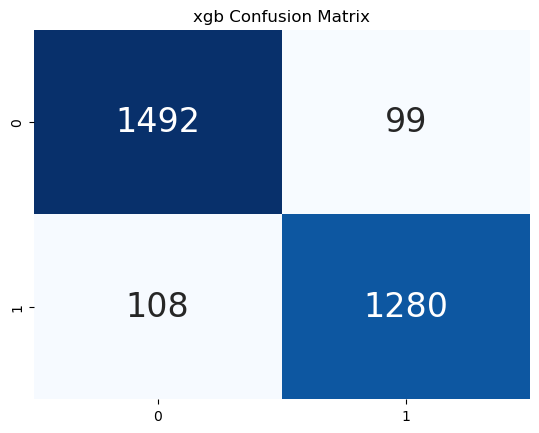

In [58]:
xgbc = xgb.XGBClassifier(random_state=42)
predictor_xgb = xgbc.fit(x_train, y_train)
y_pred = predictor_xgb.predict(x_test)

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, xgbc.predict_proba(x_test)[:, 1])
f1= f1_score(y_test, y_pred)

results = pd.DataFrame([['xgboost',acc, f1,roc]], columns = ['Model', 'Accuracy','F1 Score','ROC'])
print(results)
print('\n')
cm_xgb = confusion_matrix(y_test, y_pred)
plt.title("xgb Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
print (classification_report(y_test, y_pred))

In [59]:
#with tuning

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}


classifier=xgb.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state=42)
random_search.fit(x_train,y_train)
random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

     Model  Accuracy  F1 Score       ROC
0  xgboost  0.912722  0.903988  0.971542


              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1591
           1       0.93      0.88      0.90      1388

    accuracy                           0.91      2979
   macro avg       0.91      0.91      0.91      2979
weighted avg       0.91      0.91      0.91      2979



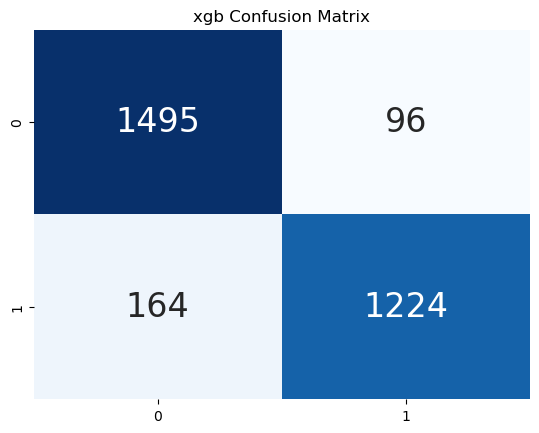

In [60]:
xgboost=xgb.XGBClassifier( colsample_bytree=0.3, enable_categorical=False,
                          gamma=0.4, learning_rate=0.15, max_depth=15, 
                          min_child_weight=1, n_estimators=100, random_state=42)
    
xgboost.fit(x_train,y_train)

from sklearn import model_selection
kfold = model_selection.KFold(n_splits=10)

y_predict_xgb = xgboost.predict(x_test)
acc = accuracy_score(y_test, y_predict_xgb)
roc = roc_auc_score(y_test, xgboost.predict_proba(x_test)[:, 1])

f1= f1_score(y_test, y_predict_xgb)

results = pd.DataFrame([['xgboost',acc, f1,roc]], columns = ['Model', 'Accuracy','F1 Score','ROC'])
print(results)
print('\n')
cm_xgb = confusion_matrix(y_test, y_predict_xgb)
plt.title("xgb Confusion Matrix")
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
print (classification_report(y_test, y_predict_xgb))

More better result with default parameters

### LSTM

In [67]:
x_train = np.array(x_train).reshape(-1,14,1)
x_test = np.array(x_test).reshape(-1,14,1)

In [68]:
print(x_train.shape, x_test.shape,y_train.shape,y_test.shape)

(11913, 14, 1) (2979, 14, 1) (11913,) (2979,)


In [69]:
def create_lstm_model(units=50, activation='relu', optimizer='adam', ):
    model = Sequential()
    model.add(LSTM(units, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

lstm_model = KerasClassifier(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)

param_grid = {
    'units': [50, 100, 150],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh', 'sigmoid'],
}

grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Get the best LSTM model with the tuned hyperparameters
best_lstm_model = grid_search.best_estimator_

Best: 0.761857 using {'activation': 'sigmoid', 'optimizer': 'adam', 'units': 150}


94/94 [==============================] - 0s 3ms/step
Accuracy Score:  0.8690835850956697
F1 Score:  0.8559822747415067
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1591
           1       0.88      0.84      0.86      1388

    accuracy                           0.87      2979
   macro avg       0.87      0.87      0.87      2979
weighted avg       0.87      0.87      0.87      2979

Confusion Matrix:


<Axes: >

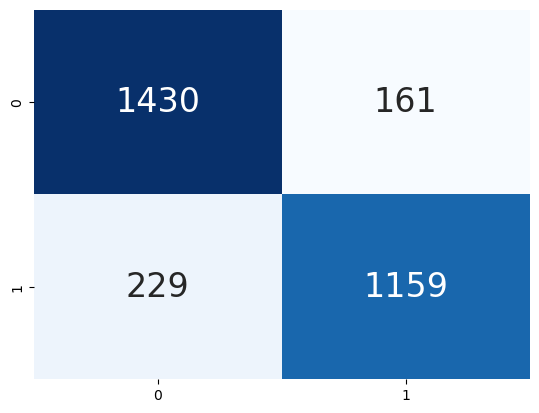

In [71]:
# Predict on the test set
y_pred = best_lstm_model.predict(x_test)

accuracy_lstm = accuracy_score(y_test, y_pred)
print("Accuracy Score: ", accuracy_lstm)

f1_lstm = f1_score(y_test, y_pred)
print("F1 Score: ", f1_lstm)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
sns.heatmap(conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

## Comparison of models


| Model                 | Accuracy   | F1 Score   |
| --------------------- | ---------- | ---------- |
| ExtraTreesClassifier  | 0.952333   | 0.947717   |
| XGBoost               | 0.930514   | 0.92519    |
| LSTM                  | 0.869084   | 0.855982   |
